# Notebook to test 

## Jupyter tools

In [4]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

## Import Libraries

In [5]:
import rasterio
import matplotlib.pyplot as plt

## Get Paths to Tiffs

In [1]:
import os
import numpy as np
import xarray as xr

def return_path_dataarray():
    incomplete_years = [1984, 1994, 2002, 2003, 2008]
    years = [year for year in range(1984, 2021) if year not in incomplete_years]
    im_type = ["hab", "chern"]
    month_groups = ["JFM", "AMJ", "JAS", "OND"]
    directory = (
        "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data"
    )
    # year, month_group, im_type
    path_array = np.empty([len(years), len(month_groups), len(im_type)], dtype=object)
    for year in years:
        if year not in incomplete_years:
            path = os.path.join(directory, str(year))
            for i in os.listdir(path):
                full_name = os.path.join(path, i)
                coord_list = [years, month_groups, im_type]
                indices = []
                for coord_no, coord in enumerate(coord_list):
                    for counter, value in enumerate(coord):
                        if str(value) in full_name:
                            indices.append(counter)
                path_array[indices[0], indices[1], indices[2]] = full_name
    da = xr.DataArray(
        data=path_array,
        dims=["yr", "mn", "ty"],
        coords=dict(
            yr=years,
            mn=month_groups,
            ty=im_type,
        ),
        attrs=dict(
            description="Paths to tif.",
        ),
    )
    return da

path_da = return_path_dataarray()

## First attempt at getting x values.

In [ ]:
import numpy as np

def return_x_values(path_da, year):
    """This seems to use up too much RAM"""
    x_list = []
    for mn in path_da.coords['mn'].values:
        for ty in path_da.coords['ty'].values:
            image = rasterio.open(path_da.sel(yr=year, mn=mn, ty=ty).values.tolist())
            x_list.append(image.read().ravel())
    return np.asarray(x_list)

return_x_values(path_da, 2000)

## Filter Files

In [2]:
import numpy as np
import numpy.ma as ma
import rasterio

def return_normalized_array(
    file_name="/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/2012/L7_chern_2012_AMJ.tif",
    filter_together=True,
    high_limit=3e3,
    low_limit=0,
    high_filter=True,
    low_filter=True,
    common_norm=True,
):
    """
    :param file_name: full path to .tif image.
    :param filter_together: if True will only display points where all 3 members of a band
            are below the threshold.
    :param high_limit: The aforementioned threshold.
    :param low_limit: Adding a lower threshold.
    :param high_filter: Bool, whether to turn the high limit on.
    :param low_filter: Bool, whether to turn the lower limit on.
    :param common_norm: Bool, whether to norm between the upper and lower limit.
    :return: void
    plots the image using matplotlib imshow.
    """
    # Open the file:
    raster = rasterio.open(file_name)
    is_land8 = "L8" in file_name     # Bool.
    
    # Convert to numpy arrays
    if is_land8:
        red, green, blue = raster.read(2), raster.read(3), raster.read(4)
    else:
        red, green, blue = raster.read(1), raster.read(2), raster.read(3)
    
    # Normalize bands into 0.0 - 1.0 scale
    def norm(array):
        array_min, array_max = np.nanmin(array), np.nanmax(array)
        if common_norm:
            return (array) / (high_limit - low_limit)
        else:
            return (array - array_min) / (array_max - array_min)
    
    def filt(data_array, filter_array):
        return ma.masked_where(filter_array, data_array).filled(np.nan)

    def filter_sep_and_norm(array):
        if high_filter:
            array = filt(array, array >= high_limit).filled(np.nan)
        if low_filter:
            array = filt(array, array <= low_limit).filled(np.nan)
        return norm(array)

    def filter_tog_and_norm(red, green, blue):
        def comb_and_filt(red, green, blue, filter_red, filter_green, filter_blue):
            filter_array = np.logical_or(
                np.logical_or(filter_red, filter_green), filter_blue
            )
            return (
                filt(red, filter_array),
                filt(green, filter_array),
                filt(blue, filter_array),
            )

        if high_filter:
            filter_red, filter_green, filter_blue = (
                red >= high_limit,
                green >= high_limit,
                blue >= high_limit,
            )
            red, green, blue = comb_and_filt(
                red, green, blue, filter_red, filter_green, filter_blue
            )
        if low_filter:
            filter_red, filter_green, filter_blue = (
                red <= low_limit,
                green <= low_limit,
                blue <= low_limit,
            )
            red, green, blue = comb_and_filt(
                red, green, blue, filter_red, filter_green, filter_blue
            )
        return norm(red), norm(green), norm(blue)

    # Normalize band DN
    if not filter_together:
        blue_norm, green_norm, red_norm = (
            filter_sep_and_norm(blue),
            filter_sep_and_norm(green),
            filter_sep_and_norm(red),
        )
    else:
        red_norm, green_norm, blue_norm = filter_tog_and_norm(red, green, blue)
    # Stack bands
    nrg = np.dstack((blue_norm, green_norm, red_norm))
    # View the color composite
    return nrg

## Preprocess to Xarray Dataarrays

In [ ]:
from tqdm import tqdm
import os

def create_netcdfs():
    for ty, ty_v in enumerate(path_da.coords["ty"].values.tolist()):
        for mn, mn_v in enumerate(path_da.coords["mn"].values.tolist()):
            da_list = []
            for yr in tqdm(range(32), ascii=True, desc=ty_v + "  " + mn_v):
                file_name = path_da.isel(yr=yr, mn=mn, ty=ty).values.tolist()
                xr_da = xr.open_rasterio(file_name)
                da = xr.DataArray(
                    data=return_normalized_array(file_name),
                    dims=["y", "x", "band"],
                    coords=dict(
                        y=xr_da.coords["y"].values,
                        x=xr_da.coords["x"].values,
                        band=["red", "green", "blue"],
                        year=path_da.isel(yr=yr).coords["yr"].values,
                    ),
                    attrs=dict(
                        description="Normalized reflectance at "+ ty_v +".",
                    ),
                )
                da_list.append(da)
            cat_da = xr.concat(da_list, "yr")
            directory = (
                "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/nc_" + ty_v
            )
            if not os.path.exists(directory):
                os.mkdir(directory)
            cat_da.astype("float32").to_netcdf(os.path.join(directory, ty_v + "_" + mn_v + ".nc"))

chern  JFM:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-2-7b7ac6873c4c>:38: RuntimeWarning: All-NaN slice encountered
  array_min, array_max = np.nanmin(array), np.nanmax(array)
chern  JFM: 100%|##########| 32/32 [10:25<00:00, 19.55s/it]


## Read Dataarray

In [14]:
import xarray as xr
import os

def return_da(ty_v="hab", mn_v="JFM"):
    directory = (
        "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/nc_" + ty_v
    )
    return xr.open_dataset(os.path.join(directory, ty_v + "_" + mn_v + ".nc")).to_array()

da = return_da()

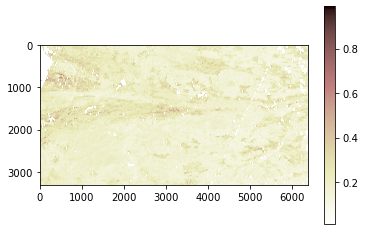

In [20]:
import matplotlib.pyplot as plt
plt.imshow(da.isel(yr=5, band=1).values[0, :, :], cmap='pink_r')
plt.colorbar()

In [13]:
da.isel(yr=5, band=1)

<xarray.Dataset>
Dimensions:                        (x: 6360, y: 3313)
Coordinates:
  * x                              (x) float64 26.89 26.89 26.89 ... 28.6 28.6
  * y                              (y) float64 52.46 52.46 52.46 ... 51.57 51.57
    year                           int32 1990
    band                           <U5 'green'
Data variables:
    __xarray_dataarray_variable__  (y, x) float64 ...

In [10]:
for mn in path_da.coords["ty"].values.tolist():
    print(mn)

hab
chern


## Check NaN values

  0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-21-78b2c73b9b6c>:37: RuntimeWarning: All-NaN slice encountered
  array_min, array_max = np.nanmin(array), np.nanmax(array)
100%|██████████| 32/32 [07:00<00:00, 13.14s/it]


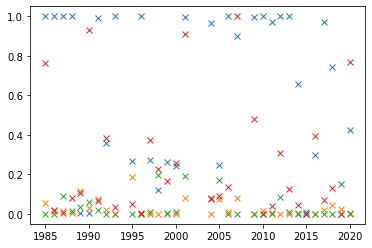

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nan_perc = [[] for x in range(4)]

for i in tqdm(range(32)):
    for j in range(4):
        a = return_normalized_array(path_da.isel(yr=i, mn=j, ty=0).values.tolist())
        nan_perc[j].append(np.isnan(a).sum()/np.prod(a.shape))

for j in range(4):
    plt.plot(path_da.coords['yr'], nan_perc[j], 'x')

plt.show()

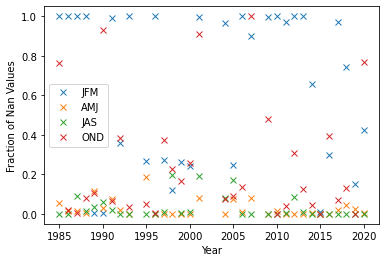

In [33]:
labels = path_da.coords['mn'].values.tolist()
for j in range(4):
    plt.plot(path_da.coords['yr'], nan_perc[j], 'x', label=labels[j])

plt.legend()
plt.ylabel('Fraction of Nan Values')
plt.xlabel('Year')
plt.show()

In [30]:
path_da.coords['mn'].values.tolist()

['JFM', 'AMJ', 'JAS', 'OND']

## Xarray Testing

In [17]:
import xarray as xr
xr_da = xr.open_rasterio("/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/2012/L7_chern_2012_AMJ.tif")

In [36]:
xr_da = xr.open_rasterio(path_da.isel(yr=31, mn=2, ty=0).values.tolist())
xr_da

<xarray.DataArray (band: 4, y: 3313, x: 6360)>
[84282720 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 52.46 52.46 52.46 52.46 ... 51.57 51.57 51.57 51.57
  * x        (x) float64 26.89 26.89 26.89 26.89 26.89 ... 28.6 28.6 28.6 28.6
Attributes:
    transform:      (0.00026949458523585647, 0.0, 26.88693577981093, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    descriptions:   ('B1', 'B4', 'B3', 'B2')
    AREA_OR_POINT:  Area

In [38]:
xr_da.values.shape

(4, 3313, 6360)

In [46]:
xr_da.coords['y'].values.shape

(3313,)

In [45]:
xr_da.coords['x'].values.shape

(6360,)

In [12]:
xr.open_rasterio(path_da.isel(yr=15, mn=2, ty=0).values.tolist())

<xarray.DataArray (band: 3, y: 3313, x: 6360)>
[63212040 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 52.46 52.46 52.46 52.46 ... 51.57 51.57 51.57 51.57
  * x        (x) float64 26.89 26.89 26.89 26.89 26.89 ... 28.6 28.6 28.6 28.6
Attributes:
    transform:      (0.00026949458523585647, 0.0, 26.88693577981093, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan, nan, nan)
    scales:         (1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0)
    descriptions:   ('B3', 'B2', 'B1')
    AREA_OR_POINT:  Area

In [14]:
xr.open_rasterio(path_da.isel(yr=1, mn=2, ty=0).values.tolist())

<xarray.DataArray (band: 3, y: 3313, x: 6360)>
[63212040 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 52.46 52.46 52.46 52.46 ... 51.57 51.57 51.57 51.57
  * x        (x) float64 26.89 26.89 26.89 26.89 26.89 ... 28.6 28.6 28.6 28.6
Attributes:
    transform:      (0.00026949458523585647, 0.0, 26.88693577981093, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:       1
    nodatavals:     (nan, nan, nan)
    scales:         (1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0)
    descriptions:   ('B3', 'B2', 'B1')
    AREA_OR_POINT:  Area

In [15]:
path_da.isel(yr=31, mn=2, ty=0).values.tolist()


'/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/gee_satellite_data/2020/L8_hab_2020_JAS.tif'